# Step 2: Baseline Model

In [15]:
import aux_functions
from transformers import TimeTransformer, BoolTransformer

import json
import joblib
import pickle
import requests

import pandas as pd
pd.set_option('display.max_columns', 100)
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
# from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, RobustScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score,  accuracy_score, roc_auc_score, make_scorer, confusion_matrix, roc_curve

# needed to use matplotlib inside jupyter notebook
%matplotlib inline 

# Data Cleaning

In [16]:
df_ = pd.read_csv("data/train.csv")
df_.head(10)

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station
0,2e4d0094-c30b-471b-a211-72a9790feca2,Person search,2020-12-01T01:10:00+00:00,NaN,50.798824,-1.089471,Male,25-34,Other ethnic group - Not stated,White,Police and Criminal Evidence Act 1984 (section 1),Article for use in theft,Community resolution,False,False,hampshire
1,4779fbe8-6e05-4534-85fd-db32952ee309,Person search,2020-12-01T02:00:00+00:00,NaN,50.785099,-1.091540,Male,over 34,White - Any other White background,Other,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,hampshire
2,cb5c685d-acac-42e2-914d-75e6ff73b0a8,Person search,2020-12-01T09:15:00+00:00,NaN,50.952006,-1.403341,Male,over 34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,True,hampshire
3,f486e116-5b1e-45db-9931-a7f070c5c478,Person search,2020-12-01T10:20:00+00:00,NaN,50.806383,-1.079844,Male,10-17,Other ethnic group - Not stated,White,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,A no further action disposal,False,False,hampshire
4,78f4020e-12cc-4889-bf1a-2f2c29b2f662,Person search,2020-12-01T10:24:00+00:00,NaN,50.806670,-1.081982,Male,10-17,Other ethnic group - Not stated,Asian,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,A no further action disposal,False,False,hampshire
5,769ac39b-cfe7-4587-855f-b574cdd46933,Person search,2020-12-01T10:30:00+00:00,NaN,50.808359,-1.079465,Male,18-24,Mixed/Multiple ethnic groups - White and Black...,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,Arrest,False,False,hampshire
6,2f3c1b3b-b41a-4b12-b1ab-3c34f93cd20a,Person search,2020-12-01T10:50:00+00:00,NaN,50.914047,-1.401123,Male,over 34,Black/African/Caribbean/Black British - Any ot...,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,True,hampshire
7,b3f957b8-b942-4789-b47c-aa1a6dfcabe7,Person search,2020-12-01T11:00:00+00:00,NaN,50.915304,-1.398959,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,hampshire
8,79807773-d027-4cdf-ad41-531b3bb2cbab,Person search,2020-12-01T11:10:00+00:00,NaN,50.830251,-1.077629,Male,18-24,Black/African/Caribbean/Black British - Caribbean,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Community resolution,False,False,hampshire
9,fa5f250a-08f0-411d-85ff-eeaab9659cb5,Person search,2020-12-01T11:10:00+00:00,NaN,50.830251,-1.077629,Male,10-17,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,hampshire


In [17]:
drop_cols = ['Self-defined ethnicity', 'Outcome', 'Outcome linked to object of search', 'Removal of more than just outer clothing']


df_clean = aux_functions.clean_data(df_, drop_cols)

# Train-test Split

In [18]:
df_train, df_test = train_test_split(df_clean, test_size=0.3, random_state=42)

df_train.head()

,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,target
699639,Person and Vehicle search,2020-05-10 14:15:00+00:00,False,51.620921,-0.391129,Male,over 34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,hertfordshire,0
367343,Person search,2020-11-09 19:45:00+00:00,<NA>,52.764399,-0.880878,Male,over 34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,leicestershire,0
735521,Person search,2021-09-21 04:38:00+00:00,False,NaN,NaN,Female,10-17,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,south-yorkshire,0
462496,Person search,2021-07-07 14:52:43+00:00,<NA>,53.400170,-2.975487,Male,10-17,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,merseyside,0
596120,Person search,2021-05-03 21:00:00+00:00,False,NaN,NaN,Male,over 34,White,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,south-yorkshire,0


# Pipeline Definition

class TimeTransformer(BaseEstimator, TransformerMixin):
    # transforms Date column into date components to be used in the model
    
    def __init__(self):
        
        return
    
    def fit(self, X, y=None):

        
        # always copy!
        X = X.copy()
        
        return self

    def transform(self, X, y=None):

        # always copy!
        X_ = X.copy()

        new = pd.DataFrame()
        new['day'] = X_['Date'].dt.day
        new['month'] = X_['Date'].dt.month
        new['year'] = X_['Date'].dt.year
        new['hour'] = X_['Date'].dt.hour
        new['day of the week'] = X_['Date'].dt.weekday
        
        return new

class BoolTransformer(BaseEstimator, TransformerMixin):
    # Fills missing values with False and converts boolean values to numeric
    
    def __init__(self):
        
        return
    
    def fit(self, X, y=None):

        
        # always copy!
        X = X.copy()
        
        return self

    def transform(self, X, y=None):

        # always copy!
        X_ = X.copy()

        X_['Part of a policing operation'] = X_['Part of a policing operation'].fillna(value=False)
        X_['Part of a policing operation'] = X_['Part of a policing operation'] * 1.0
        
        return X_

In [19]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()

    # Encode Target data
    # lb = LabelEncoder()
    # lb.fit(y)
    # y_bin = pd.DataFrame(data= lb.transform(y), columns= ['readmitted'])

    # categorical_cols = list(X.select_dtypes(include=['object']).columns)
    # numerical_cols = list(X.select_dtypes(include=['number']).columns)
    time_cols = ['Date']

    categorical_cols = ['Type', 'Gender', 'Age range', 'Officer-defined ethnicity', 'Legislation', 'Object of search', 'station']
    
    bool_cols = ['Part of a policing operation']

    numerical_cols = ['Latitude', 'Longitude']

    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer())
        ])

    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            # ('imputer', SimpleImputer(strategy='constant', fill_value=False)),
            ('bool_transformer', BoolTransformer())
        ])

    # Define numerical pipeline
    numeric_pipe = Pipeline([
            ('imputer', SimpleImputer()),
            ('scaler', StandardScaler())
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols),
        ('num', numeric_pipe, numerical_cols)],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])
 

    pipeline.fit(X, np.ravel(y))
    # pipeline.fit(X, np.ravel(y_bin))


    return pipeline, X, y


def see_cross_val(pipeline, X, y):

    roc_scorer = make_scorer(accuracy_score)

    roc_aucs = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=roc_scorer)
    print(roc_aucs)

In [20]:

model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)


see_cross_val(pipeline, X_train, y_train)

[0.8104792  0.81212988 0.81068341 0.80876047 0.81013886]


In [21]:
# check transformation results

X_df = pd.DataFrame(data=pipeline.named_steps['preprocessor'].transform(X_train), columns=['day', 'month', 'year', 'hour', 'day of the week','Type', 'Gender', 'Age range', 
                                                                                           'Officer-defined ethnicity', 'Legislation', 'Object of search', 'station',
                                                                                            'Part of a policing operation',
                                                                                            'Latitude', 'Longitude'])
X_df

,day,month,year,hour,day of the week,Type,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,Part of a policing operation,Latitude,Longitude
0,10,5,2020,14,6,0.0,1.0,3.0,4.0,10.0,3.0,16.0,0.0,-0.830831,0.81795
1,9,11,2020,19,0,1.0,1.0,3.0,4.0,10.0,3.0,20.0,0.0,0.312129,0.40776
2,21,9,2021,4,1,1.0,0.0,0.0,4.0,12.0,13.0,29.0,0.0,-0.0,0.0
3,7,7,2021,14,2,1.0,1.0,0.0,4.0,10.0,3.0,22.0,0.0,0.947611,-1.346583
4,3,5,2021,21,0,1.0,1.0,3.0,4.0,12.0,16.0,29.0,0.0,-0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293815,31,10,2021,22,6,1.0,1.0,0.0,4.0,10.0,3.0,33.0,0.0,-1.435894,1.020782
293816,22,2,2020,20,5,0.0,0.0,2.0,4.0,12.0,16.0,13.0,0.0,-0.655629,2.109389
293817,14,6,2020,22,6,1.0,1.0,3.0,4.0,12.0,13.0,29.0,0.0,-0.0,0.0
293818,12,12,2021,2,6,1.0,1.0,2.0,4.0,10.0,3.0,8.0,0.0,0.782513,-0.046388


In [22]:
# use the pipeline and get predictions and probas

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
# get the probas
y_hat = pipeline.predict_proba(X_test)

In [23]:
# Major label percentage

df_clean['target'].value_counts()[0]/len(df_clean['target'])

0.8322616458166068

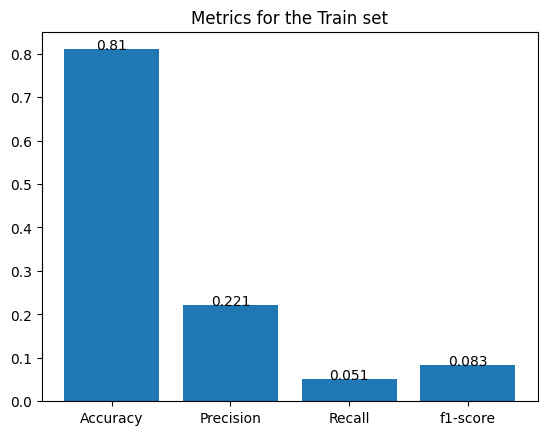

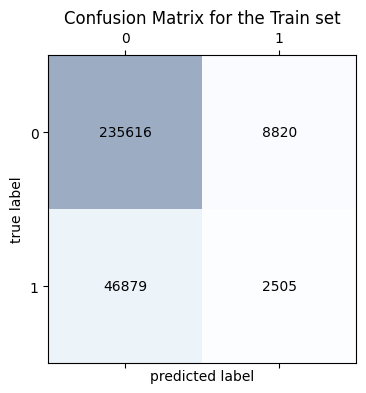

In [24]:
# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

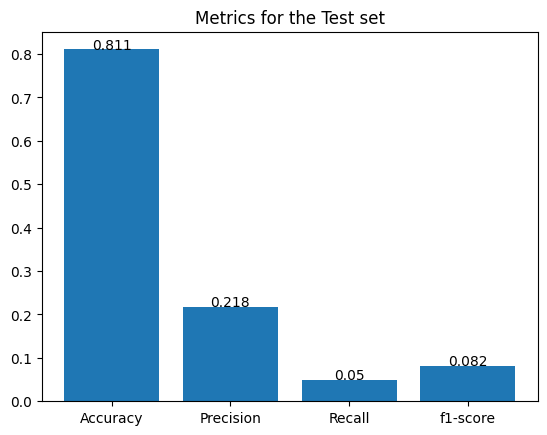

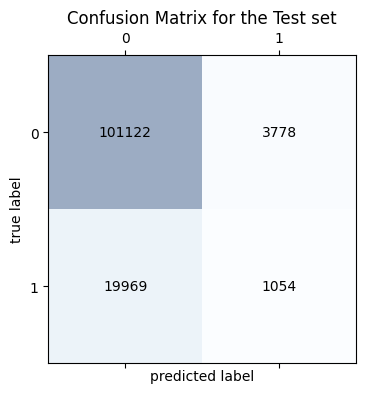

In [25]:
# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred)

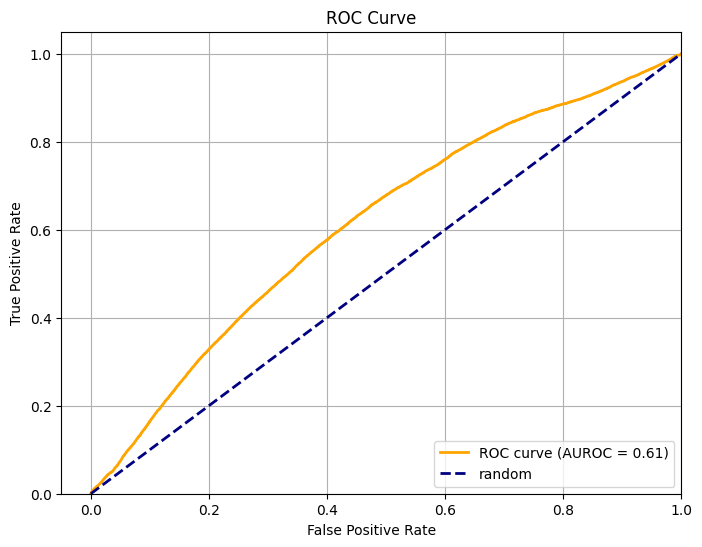

In [26]:
# show roc_curve

aux_functions.plot_roc_curve(y_test, y_hat)

In [27]:
# check transformation results

X_train.columns

Index(['Type', 'Date', 'Part of a policing operation', 'Latitude', 'Longitude',
       'Gender', 'Age range', 'Officer-defined ethnicity', 'Legislation',
       'Object of search', 'station'],
      dtype='object')

In [28]:
with open("columns.json", 'w') as fh:
    json.dump(X_train.columns.tolist(), fh)


with open("dtypes.pickle", 'wb') as fh:
    pickle.dump(X_train.dtypes, fh)

joblib.dump(pipeline, "pipeline.pickle") 

['pipeline.pickle']

In [30]:
APP_NAME = 'ldsacapstone-production.up.railway.app'

In [35]:
X_train.loc[0, :].to_dict()

{'Type': 'Person search',
 'Date': Timestamp('2020-12-01 01:10:00+0000', tz='UTC'),
 'Part of a policing operation': <NA>,
 'Latitude': 50.798824,
 'Longitude': -1.089471,
 'Gender': 'Male',
 'Age range': '25-34',
 'Officer-defined ethnicity': 'White',
 'Legislation': 'Police and Criminal Evidence Act 1984 (section 1)',
 'Object of search': 'Article for use in theft',
 'station': 'hampshire'}

In [38]:
url = f"https://{APP_NAME}/predict"
payload = {
    "id": 0,
    "observation": {'Type': 'Person search',
                    'Date': '2020-12-01 01:10:00+0000',
                    'Part of a policing operation': False,
                    'Latitude': 50.798824,
                    'Longitude': -1.089471,
                    'Gender': 'Male',
                    'Age range': '25-34',
                    'Officer-defined ethnicity': 'White',
                    'Legislation': 'Police and Criminal Evidence Act 1984 (section 1)',
                    'Object of search': 'Article for use in theft',
                    'station': 'hampshire'}
    }

r = requests.post(url, json=payload)